### Import Modules

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn')

import statsmodels.api as sm  

from statsmodels.tsa.stattools import acf,pacf,adfuller

from neupy.estimators import mse
import test_stationarity

import datetime
from dateutil.relativedelta import relativedelta

from GM11 import GM11

In [2]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
#     rolmean = pd.rolling_mean(timeseries, window=12)
    rolmean = timeseries.rolling(window=12,center=False).mean()
#     rolstd = pd.rolling_std(timeseries, window=12)
    rolstd = timeseries.rolling(window=12,center=False).std()

    #Plot rolling statistics:
    fig = plt.figure(figsize=(8, 6))
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()
    
    #Perform Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='BIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [3]:
datasets = pd.read_excel('../Data/TB_nation.xlsx',index_col='Date')
datasets = datasets[datasets.index > '2004-12-01']

### Exploratory analysis

In [4]:
print("Mean is:",np.mean(datasets.Incidence_rate),"Total Number:",np.sum(datasets.Incidence))

Mean is: 6.58067217528 Total Number: 10487265


### Data Split

In [5]:
datasets_pred = datasets[datasets.index >= '2013-01-1']
datasets = datasets[datasets.index < '2013-01-01']

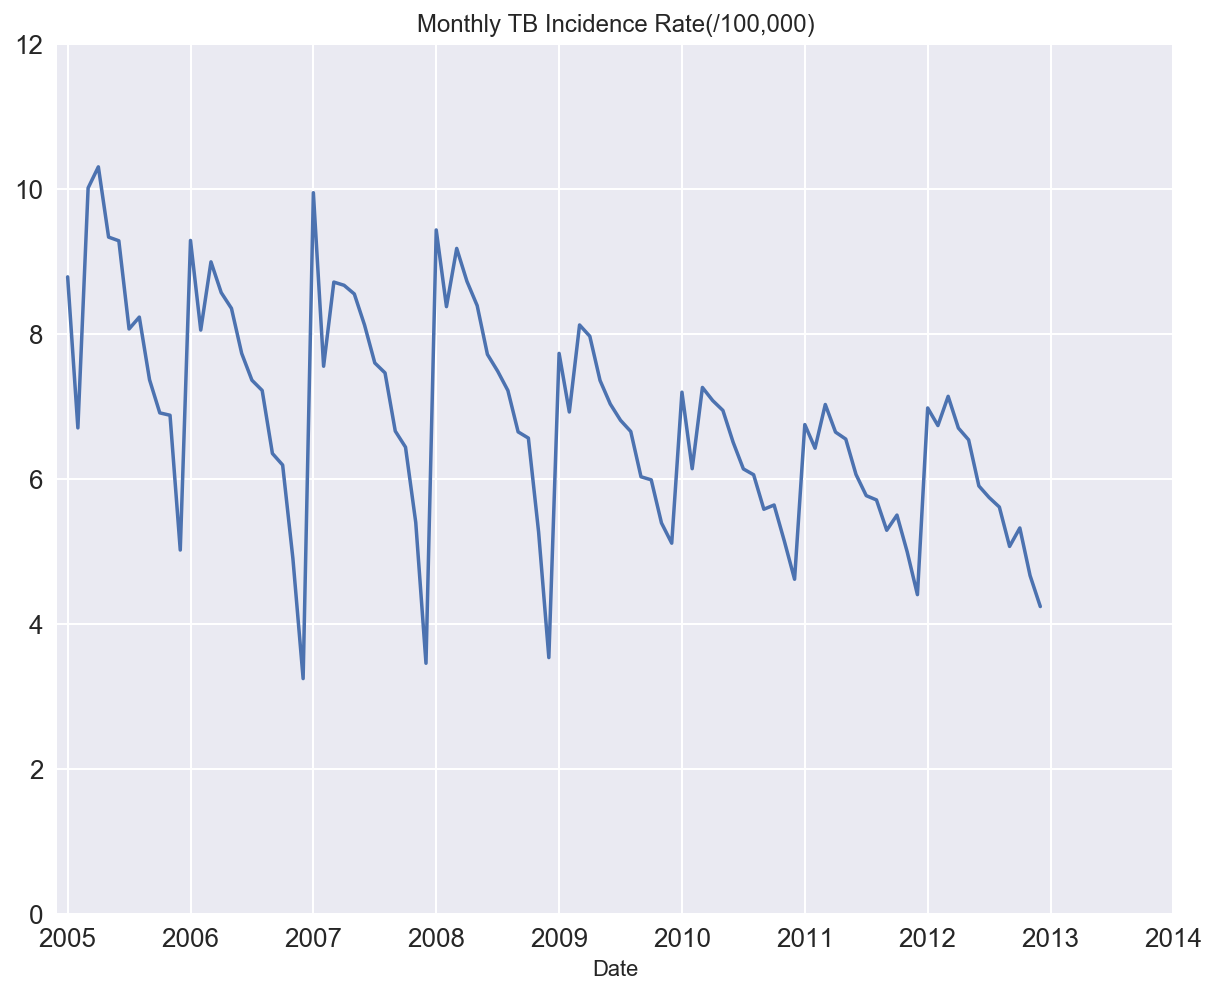

In [6]:
datasets.Incidence_rate.plot(figsize=(10,8), title= 'Monthly TB Incidence Rate(/100,000)',fontsize=13,ylim=(0,12),xlim=('2004-12','2014-01'))
# plt.savefig('month_TB.png',dpi=600)

### Difference

In [7]:
datasets['first_diff'] = datasets.Incidence_rate - datasets.Incidence_rate.shift(1)
datasets['seasonal_difference'] = datasets.Incidence_rate - datasets.Incidence_rate.shift(12)
datasets['seasonal_first_difference'] = datasets.first_diff-datasets.first_diff.shift(12)

### Test of stationarity

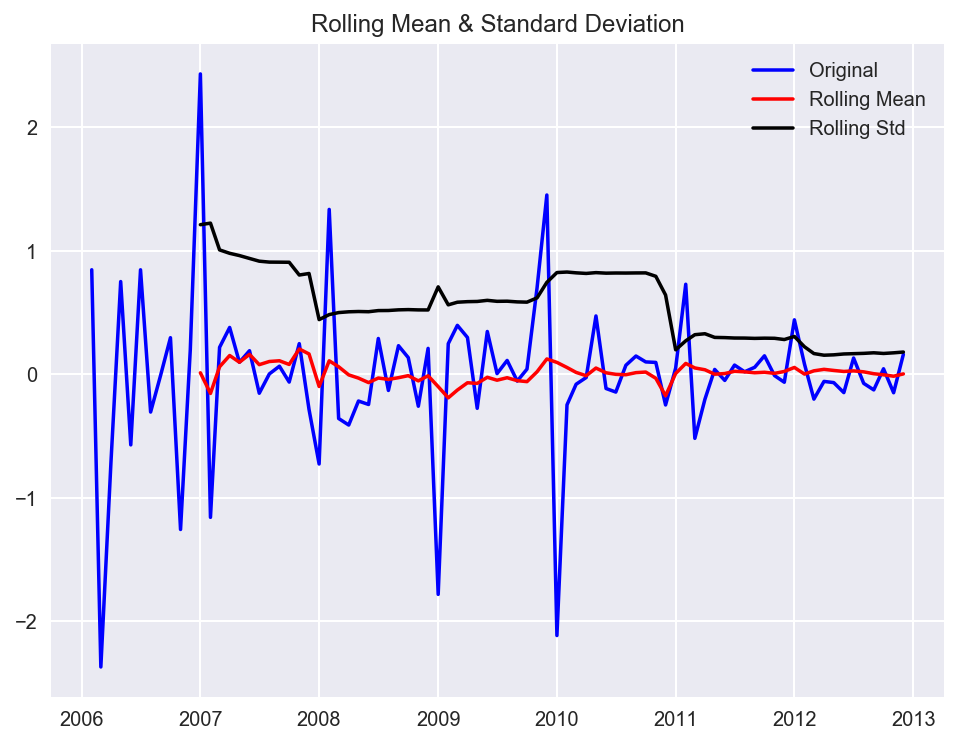

Results of Dickey-Fuller Test:
Test Statistic                -1.018956e+01
p-value                        6.375189e-18
#Lags Used                     1.000000e+00
Number of Observations Used    8.100000e+01
Critical Value (1%)           -3.513790e+00
Critical Value (5%)           -2.897943e+00
Critical Value (10%)          -2.586191e+00
dtype: float64


In [8]:
test_stationarity(datasets.seasonal_first_difference.dropna(inplace=False))

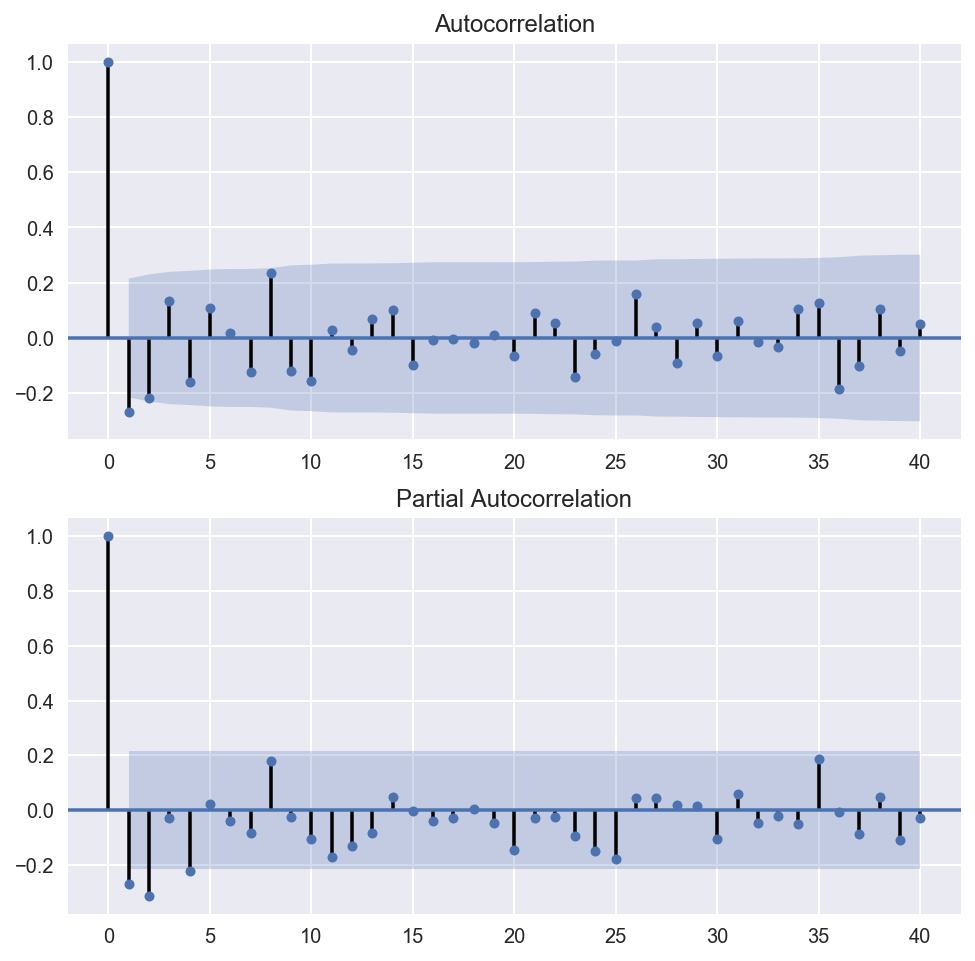

In [9]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(datasets.seasonal_first_difference.iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(datasets.seasonal_first_difference.iloc[13:],lags=40, ax=ax2)
# fig.savefig('ARIMA.png',dpi=600)

In [10]:
dta = pd.concat([datasets, datasets_pred])[['Incidence','Incidence_rate','Year','Month']]

### Model diagnostics

In [11]:
mod = sm.tsa.SARIMAX(datasets.Incidence_rate, trend='n', order=(0,1,2), seasonal_order=(0,1,0,12))
results = mod.fit()
print(results.summary())

                                 Statespace Model Results                                 
Dep. Variable:                     Incidence_rate   No. Observations:                   96
Model:             SARIMAX(0, 1, 2)x(0, 1, 0, 12)   Log Likelihood                 -70.330
Date:                            Mon, 20 Mar 2017   AIC                            146.660
Time:                                    21:03:14   BIC                            154.353
Sample:                                01-01-2005   HQIC                           149.770
                                     - 12-01-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4012      0.103     -3.902      0.000      -0.603      -0.200
ma.L2         -0.4153      0.093   

In [12]:
dta['forecast'] = results.predict(start=13,end=131,dynamic=False)

In [13]:
dta['error_ARIMA'] = dta['Incidence_rate']-dta['forecast']

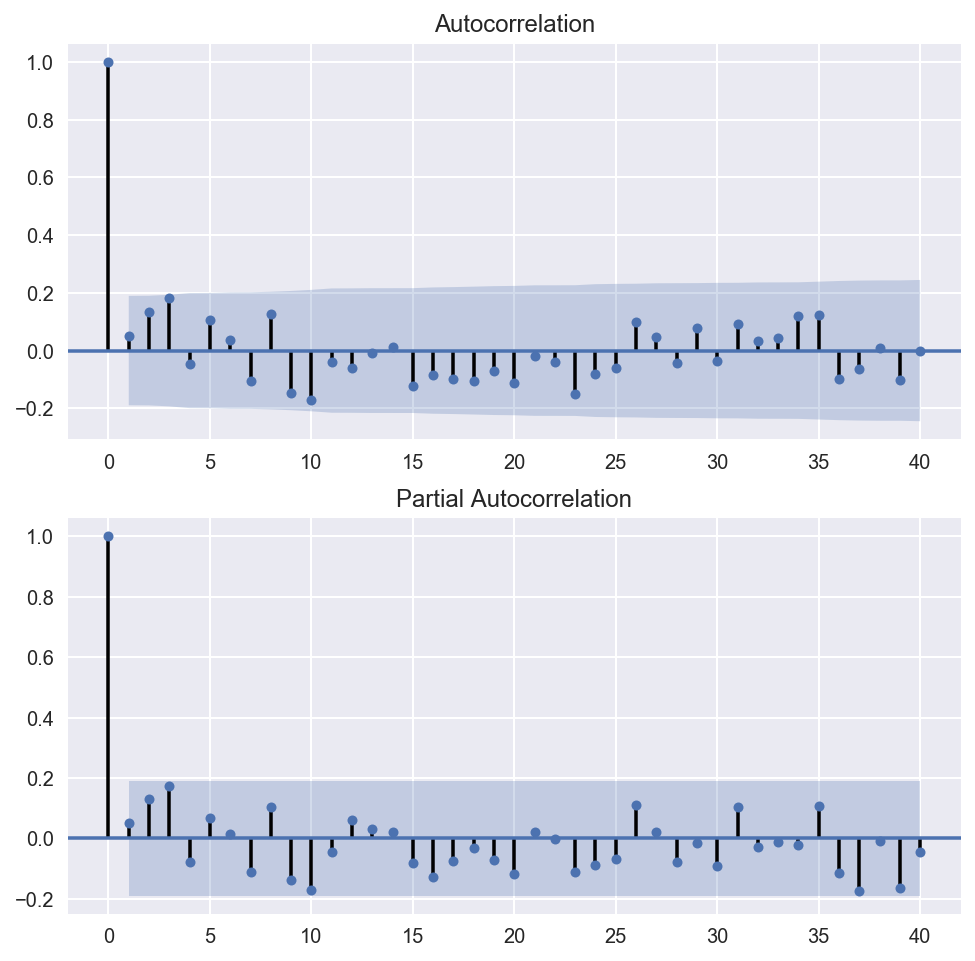

In [14]:
fig = plt.figure(figsize=(8,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(dta.error_ARIMA.iloc[13:],lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(dta.error_ARIMA.iloc[13:],lags=40, ax=ax2)
# fig.savefig('Error_ARIMA.png',dpi=600)

### Time series of forecasting

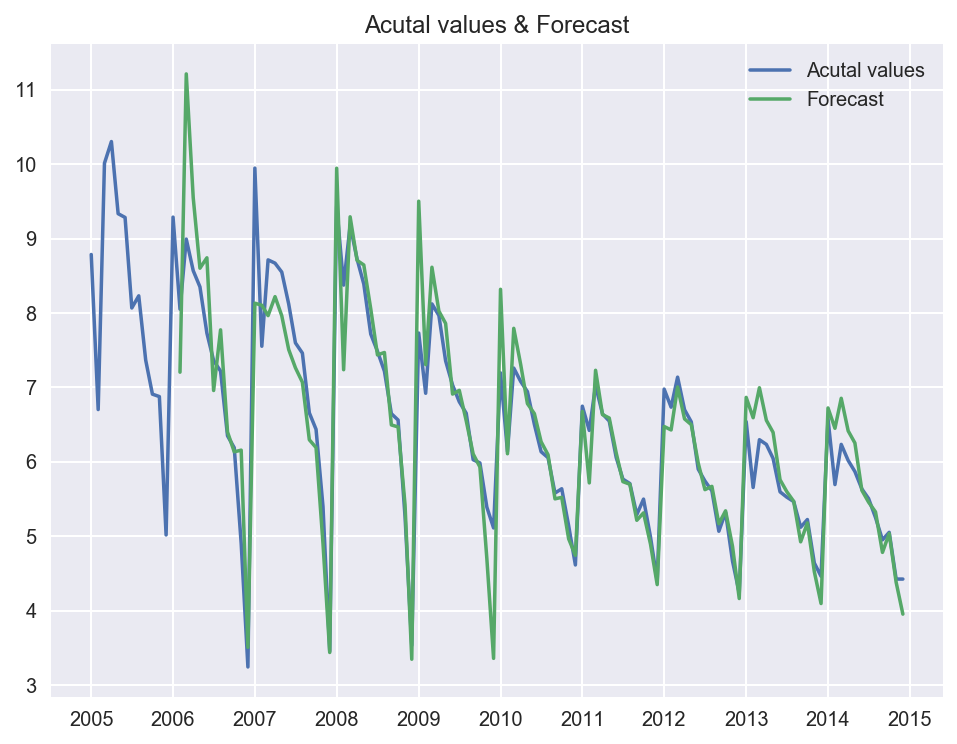

In [15]:
fig = plt.figure(figsize=(8, 6))
plt.plot(dta.Incidence_rate,label='Acutal values')
plt.plot(dta.forecast, label='Forecast')
plt.legend(loc='best')
plt.title('Acutal values & Forecast')
# fig.savefig('Forecast_Time_Series.png',dpi=600)

In [16]:
start = datetime.datetime.strptime("2015-01-01", "%Y-%m-%d")
date_list = [start + relativedelta(months=x) for x in range(0,132)]
future = pd.DataFrame(index=date_list, columns= dta.columns)
TB_future = pd.concat([dta,future])

In [17]:
TB_future['forecast'] = results.predict(start = 13, end = 263, dynamic= False)
TB_future['Year'] = TB_future.index.year
TB_future[['forecast','Incidence_rate','Year']].groupby('Year').apply(lambda x:np.sum(x))[['forecast','Incidence_rate']]

,forecast,Incidence_rate
Year,,
2005,NaN,96.878875
2006,82.231552,86.234749
2007,83.038640,88.549250
2008,88.512450,88.515012
2009,81.811743,81.093508
2010,76.044015,74.272892
2011,70.161727,71.091647
2012,69.790232,70.620700
2013,68.947404,66.795220


In [18]:
TB_year = TB_future[['forecast','Incidence_rate','Year']].groupby('Year').apply(lambda x:np.sum(x))[['forecast','Incidence_rate']]

## Grey Model

In [19]:
nation = pd.read_csv('./Results/nation_TB1.csv')[['incidence rate']]
nation.index=range(2005,2015)

In [20]:
for k in range(2015,2026):
    nation.loc[k] = None

nation['incidence_rate'] = None

for k in range(2005,2026):
    f = GM11(nation.loc[range(2005,2015),'incidence rate'].as_matrix())
    nation['incidence_rate'].loc[k] = f[0](k-2005+1).round(2)
nation

/Users/Evan/miniconda3/lib/python3.6/site-packages/pandas/core/indexing.py:141: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,incidence rate,incidence_rate
2005,96.878875,94.29
2006,86.234749,90.44
2007,88.549250,86.74
2008,88.515012,83.19
2009,81.093508,79.79
2010,74.272892,76.53
2011,71.091647,73.4
2012,70.620700,70.4
2013,66.795220,67.52
2014,65.628808,64.76


In [21]:
data = nation.join(TB_year,how='outer')
data['error_ARIMA']= data['forecast'] - data['incidence rate']
data['error_GM']= data['incidence_rate'] - data['incidence rate']
data['error_GM_rate'] = data['error_GM']/data['incidence rate']*100
data['error_ARIMA_rate'] = data['error_ARIMA']/data['incidence rate']*100

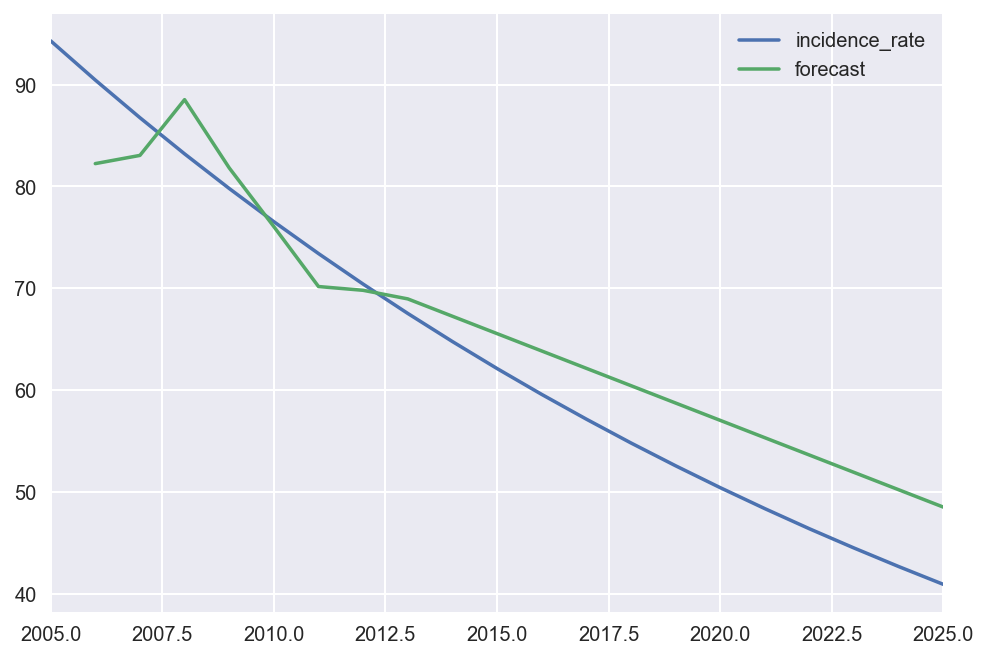

In [22]:
data[['incidence_rate','forecast']].plot()

In [23]:
data.to_excel('data_predict.xlsx')

In [24]:
result_final = data[data.index <= 2014]

In [25]:
result_final_2014 = data[(data.index <= 2014) & (data.index >= 2005)]
result_final_2014

,incidence rate,incidence_rate,forecast,Incidence_rate,error_ARIMA,error_GM,error_GM_rate,error_ARIMA_rate
2005,96.878875,94.29,NaN,96.878875,NaN,-2.58888,-2.67228,NaN
2006,86.234749,90.44,82.231552,86.234749,-4.003197,4.20525,4.87652,-4.642208
2007,88.549250,86.74,83.038640,88.549250,-5.510611,-1.80925,-2.04321,-6.223216
2008,88.515012,83.19,88.512450,88.515012,-0.002562,-5.32501,-6.01594,-0.002895
2009,81.093508,79.79,81.811743,81.093508,0.718235,-1.30351,-1.60741,0.885688
2010,74.272892,76.53,76.044015,74.272892,1.771123,2.25711,3.03894,2.384616
2011,71.091647,73.4,70.161727,71.091647,-0.929920,2.30835,3.24701,-1.308058
2012,70.620700,70.4,69.790232,70.620700,-0.830469,-0.2207,-0.312515,-1.175956
2013,66.795220,67.52,68.947404,66.795220,2.152184,0.72478,1.08508,3.222062
2014,65.628808,64.76,67.243233,65.628808,1.614425,-0.868808,-1.32382,2.459934


In [26]:
np.sum(abs(result_final_2014.error_GM_rate))/10

2.6222728413862626

In [27]:
result_dta = result_final_2014[result_final_2014.index > 2006]
np.sum(abs(result_dta.error_GM_rate))/8

2.3342414737284667

In [29]:
mape(result_final.Incidence_rate, result_final.incidence_rate)
mse(result_final.Incidence_rate, result_final.incidence_rate)
rmse(result_final.Incidence_rate, result_final.incidence_rate)

NameError: name 'mape' is not defined

In [ ]:
mse(result_final_2014.Incidence_rate, result_final_2014.incidence_rate)
rmse(result_final_2014.Incidence_rate, result_final_2014.incidence_rate)
mape(result_final_2014.Incidence_rate, result_final_2014.incidence_rate)

In [ ]:
dta = data[data.index >= 2007]

In [ ]:
dta

In [ ]:
fig = plt.figure(figsize=(8,6))
plt.plot(dta.Incidence_rate,label='Acutal values')
plt.plot(dta.forecast, label='ARIMA')
plt.plot(dta.incidence_rate, label='GM')
plt.legend(loc='best')
plt.title('Acutal values & Forecast')
# fig.savefig('Forecast_Time_Series.png',dpi=600)

In [ ]:
data['mean'] = (data['incidence_rate']+data['forecast'])/2

In [ ]:
def development_rate(start,end,year):
    return ((end/start)**(1/year)-1)*100

In [ ]:
development_rate(data.loc[2005,'incidence rate'],data.loc[2014,'incidence rate'],10)

In [ ]:
development_rate(data.loc[2015,'incidence_rate'],data.loc[2025,'incidence_rate'],11)

In [ ]:
development_rate(data.loc[2015,'forecast'],data.loc[2025,'forecast'],11)

In [ ]:
development_rate(data.loc[2015,'incidence_rate'],data.loc[2020,'incidence_rate'],6)

In [ ]:
development_rate(data.loc[2015,'forecast'],data.loc[2020,'forecast'],6)

In [ ]:
dta.to_excel('/Users/Evan/Desktop/result.xlsx')